# arXiv:1906.06329 TensorNetwork for Machine Learning

In [1]:
%%bash

pip install torchinfo

In [2]:
from __future__ import annotations

import math
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchinfo
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader

In [3]:
root = os.path.join(os.getenv('HOME'), '.torch')

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

use_fashion_mnist = False

default_pix_dims = 2  # dimension of feature space
default_bond_dims = 10  # common dimension of virtual indices
img_size = 28
n_feature = img_size * img_size

transform = transforms.Compose([
    # transforms.Resize(img_size),
    transforms.ToTensor(),
])

if use_fashion_mnist:
    trainset = torchvision.datasets.FashionMNIST(
        root=root,
        train=True,
        download=True,
        transform=transform
    )

    testset = torchvision.datasets.FashionMNIST(
        root=root,
        train=False,
        download=True,
        transform=transform
    )
else:
    trainset = torchvision.datasets.QMNIST(
        root=root,
        train=True,
        download=True,
        transform=transform
    )

    testset = torchvision.datasets.QMNIST(
        root=root,
        train=False,
        download=True,
        transform=transform
    )

100%|██████████| 9704059/9704059 [00:00<00:00, 98048683.70it/s]

Extracting /root/.torch/QMNIST/raw/qmnist-train-images-idx3-ubyte.gz to /root/.torch/QMNIST/raw


100%|██████████| 463024/463024 [00:00<00:00, 14778545.29it/s]

Extracting /root/.torch/QMNIST/raw/qmnist-train-labels-idx2-int.gz to /root/.torch/QMNIST/raw


100%|██████████| 9742279/9742279 [00:00<00:00, 98509130.26it/s]

Extracting /root/.torch/QMNIST/raw/qmnist-test-images-idx3-ubyte.gz to /root/.torch/QMNIST/raw


100%|██████████| 526800/526800 [00:00<00:00, 15547029.27it/s]

Extracting /root/.torch/QMNIST/raw/qmnist-test-labels-idx2-int.gz to /root/.torch/QMNIST/raw


In [4]:
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size = 32,
    shuffle=True,
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size = 32,
    shuffle=False,
)

## Visualization

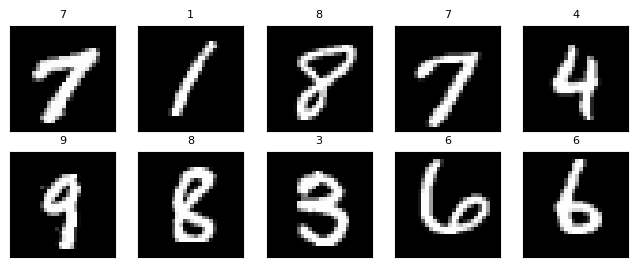

In [5]:
imgs, labels = next(iter(trainloader))
images = imgs.numpy()
labels = labels.numpy()

images = [Image.fromarray((img.squeeze() * 255).astype("uint8")) for img in images]

row = 2
col = 5
n_data = row * col

fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(8,3))
for i, img in enumerate(images[:n_data]):
    r= i // col
    c= i % col
    ax[r, c].set_title(labels[i], fontsize=8)
    ax[r, c].axes.xaxis.set_visible(False)
    ax[r, c].axes.yaxis.set_visible(False)
    ax[r, c].imshow(img, cmap="gray")

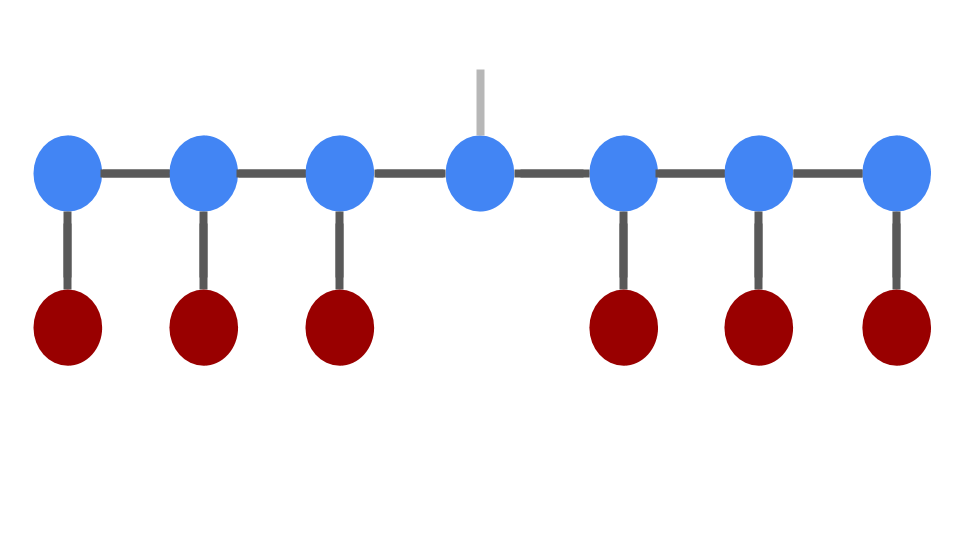

```python
einsum(
    "Bi,Bj,Bk,Bl,Bm,Bn" + \
    "iα,jαβ,kβγ,Cγδ,lδε,mmζ,nζ" + \
    "->BC",
    x1, x2, x3, x4, x5, x6, A1, A2, A3, C, A4, A5, A6,
)
```

## Define the model

In [6]:
def make_tt(
    n_feature: int, pix_dims: int, bond_dims: int, n_class: int, classifier_idx: int | None = None,
    std: float = 1e-3, use_google_initialization: bool = True,
) -> list[torch.Tensor]:
    tt_cores = []
    for i in range(n_feature):
        if i == 0 or i == n_feature - 1:
            dims = (pix_dims, bond_dims)
            if use_google_initialization:
                core = torch.zeros(dims)
                core[:, 0] = 1
                core += torch.normal(mean=0.0, std=std, size=core.shape)
            else:
                core = torch.normal(mean=torch.zeros(dims), std=torch.ones(dims) * std)
        else:
            if use_google_initialization:
                core = torch.tensor(np.array(pix_dims * [np.eye(bond_dims)], dtype=np.float32))
                core += torch.normal(mean=0.0, std=std, size=core.shape)
            else:
                dims = (pix_dims, bond_dims, bond_dims)
                core = torch.normal(mean=torch.zeros(dims), std=torch.ones(dims) * std)
        tt_cores.append(core)
    if classifier_idx is not None:
        if use_google_initialization:
            core = torch.tensor(np.array(n_class * [np.eye(bond_dims)], dtype=np.float32))
            core += torch.normal(mean=0.0, std=std, size=core.shape)
        else:
            dims = (n_class, bond_dims, bond_dims)
            core = torch.normal(mean=torch.zeros(dims), std=torch.ones(dims) * std)
        tt_cores.insert(classifier_idx, core)
    return tt_cores


class FeatureEmbeddingLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torchTensor) -> tuple[torchTensor, ...]:
        x = torch.flatten(x, start_dim=1)
        x = torch.stack([1-x, x], axis=1).permute((2, 0, 1))  # [[[1-x1, x1]], [[1-x2, x2]], ...]
        x = tuple(t.squeeze() for t in x.split(1))
        # n_feature tensors whose shape is (n_batch, pix_dims)
        return x

In [7]:
class WeightLayer(nn.Module):
    def __init__(self, n_feature: int, pix_dims: int, bond_dims: int, n_class: int):
        super().__init__()
        self.n_feature = n_feature
        classifier_idx = self.classifier_loc(n_feature)
        tt_cores = make_tt(n_feature, pix_dims, bond_dims, n_class, classifier_idx=classifier_idx)
        self.n_cores = len(tt_cores)
        for i, core in enumerate(tt_cores):
            param_core = nn.parameter.Parameter(core)
            setattr(self, f"tt_core{i}", param_core)

    def forward(self, x: tuple[torchTensor, ...], n_sub_features: int = 2):
        # n_sub_features=2, to prevent a term value not to disappear (XXX 20 for 7x7, 18 for 14x14, 20 for 28x28)
        classifier_idx = self.classifier_loc(self.n_feature)
        assert n_sub_features * 2 < self.n_feature, f"{n_sub_features*2=} must be < {self.n_feature=}"
        n_left_right_block, n_remaining_fea = self.left_sub_feature_num(n_sub_features)

        # left to right before classifier
        start = 0
        prev_t = None
        for i in range(n_left_right_block):
            end = start + n_sub_features
            equation = self._make_equation(self.n_feature, start_fea=start, end_fea=end)
            t = torch.einsum(equation, *x[start:end], *self.tt_cores[start:end])
            if prev_t is None:
                prev_t = t
            else:
                prev_t = torch.einsum("ab,abc->ac", prev_t, t)

            start += n_sub_features
        left_t = prev_t

        # right to left after classifier
        start = n_sub_features * (n_left_right_block * 2 - 1) + n_remaining_fea
        prev_t = None
        for i in range(n_left_right_block):
            end = start + n_sub_features
            equation = self._make_equation(self.n_feature, start_fea=start, end_fea=end)
            # +1 for tt_cores means consideration of shift for the classifier site
            t = torch.einsum(equation, *x[start:end], *self.tt_cores[start + 1:end + 1])
            if prev_t is None:
                prev_t = t
            else:
                prev_t = torch.einsum("abc,ac->ab", t, prev_t)

            start -= n_sub_features
        right_t = prev_t

        start = n_left_right_block * n_sub_features
        end = start + n_remaining_fea
        equation = self._make_equation(self.n_feature, start_fea=start, end_fea=end)
        # +1 for tt_cores means consideration of including the classifier site
        classifier_t = torch.einsum(equation, *x[start:end], *self.tt_cores[start:end + 1])
        output = torch.einsum("ab,aAbc,ac->aA", left_t, classifier_t, right_t)
        return output

    def forward_full(self, x: tuple[torchTensor, ...]):
        equation = self._make_equation(self.n_feature)
        output = torch.einsum(equation, *x, *self.tt_cores)
        return output

    def left_sub_feature_num(self, n_sub_features) -> tuple[int, int]:
        remaining = self.n_feature
        i = 0
        while remaining > n_sub_features * 2:
            remaining = remaining - n_sub_features * 2
            i += 1
        return i, remaining

    @property
    def tt_cores(self):
        return [getattr(self, f"tt_core{i}") for i in range(self.n_cores)]

    @classmethod
    def classifier_loc(cls, n_feature):
        return n_feature // 2

    @classmethod
    def _make_equation(
        cls, n_feature: int, start_fea: int = 0, end_fea: int | None = None, batch_c: str = "a", class_c: str | None = "A"
    ):
        """make an equation for range(start_i, end_i)
        """

        if start_fea < 0:
            raise ValueError(f'{start_fea=} must be >= 0.')

        if end_fea is None:
            end_fea = n_feature

        if end_fea > n_feature:
            raise ValueError(f'{end_fea=} must be <= {n_feature=}.')

        if start_fea >= end_fea:
            raise ValueError(f'{start_fea=} must be less than {end_fea=}.')

        if end_fea - start_fea > ord("Z") - ord("B") + 1:
            raise ValueError(f'{end_fea=} - {start_fea=} must be less than {ord("Z") - ord("B") + 1}.')

        classifier_idx = cls.classifier_loc(n_feature)

        includes_classifier = start_fea <= classifier_idx <= end_fea - 1

        fea_i = ord("B")  # U+0042-
        vir_i = ord("b")  # U+0062-

        fea_idx: list[str] = []
        vir_idx: list[str] = []  # ["Bb", "Cbc", "Dc"]
        pre_vir_idx: list[tuple[str, ...]] = []  # [("B", "b"), ("C", "b", "c"), ("D", "c")]
        for i in range(start_fea, end_fea):
            fea_idx.append(chr(fea_i))
            if i == 0:
                vir_i -= 1  # preserve first vir_i
                pre_vir_idx.append((chr(fea_i), chr(vir_i + 1)))
            elif i == n_feature - 1:
                pre_vir_idx.append((chr(fea_i), chr(vir_i)))
            else:
                pre_vir_idx.append((chr(fea_i), chr(vir_i), chr(vir_i + 1)))
            fea_i += 1
            vir_i += 1

        def next_vir_idx(idx: str):
            return chr(ord(idx) + 1)

        classifier_loc = classifier_idx - start_fea
        for i, idx in enumerate(pre_vir_idx):
            if includes_classifier:
                if i == classifier_loc:
                    if i == 0:
                        vir_i = idx[1]
                        classifier_idx = f"{class_c}{vir_i}{next_vir_idx(vir_i)}"
                        vir_idx.append(classifier_idx)
                    else:
                        last_vir_idx = vir_idx[-1][-1]
                        classifier_idx = f"{class_c}{last_vir_idx}{next_vir_idx(last_vir_idx)}"
                        vir_idx.append(classifier_idx)
                if i >= classifier_loc:
                    idx = [c if ord(c) < ord("a") else next_vir_idx(c) for c in list(idx)]
            vir_idx.append("".join(idx))

        fea_idx_s = ",".join([f"{batch_c}{c}"for c in fea_idx])

        vir_idx_s = ",".join(vir_idx)  # Ba,Cab,Db (no-classifier) or Ba,Aab,Cb (classifier) etc.
        out_index = batch_c
        first_idx = vir_idx[0]
        last_idx = vir_idx[-1]
        if class_c in vir_idx_s:
            out_index += class_c
        if len(first_idx) >= 3 and ord(first_idx[1]) >= ord("a"):  # e.g., "Bab"'s 'a'. "Ba"'s 'a' is ignored.
            out_index += first_idx[1]
        if len(last_idx) >= 3 and ord(last_idx[-1]) >= ord("a"):  # e.g., "Bab"'s 'b'. "Ba"'s 'a' is ignored.
            out_index += last_idx[-1]

        equation = f'{fea_idx_s + "," + vir_idx_s}->{out_index}'

        return equation


class Net(nn.Module):
    def __init__(self, n_feature: int, pix_dims: int, bond_dims: int, n_class: int):
        super().__init__()

        self.fea_layer = FeatureEmbeddingLayer()
        self.wgt_layer = WeightLayer(
            n_feature=n_feature, pix_dims=pix_dims, bond_dims=bond_dims, n_class=n_class
        )
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, *args):
        x = self.fea_layer(x)
        x = self.wgt_layer(x, *args)
        x = self.softmax(x)
        return x

    def forward_full(self, x):
        x = self.fea_layer(x)
        x = self.wgt_layer.forward_full(x)
        x = self.softmax(x)
        return x

In [8]:
if False:
    fea_layer = FeatureEmbeddingLayer()
    wgt_layer = WeightLayer(n_feature=n_feature, pix_dims=default_pix_dims, bond_dims=default_bond_dims, n_class=10)
    wgt_layer = wgt_layer.to(device)
    imgs, labels = next(iter(trainloader))
    imgs = imgs.to(device)
    labels = labels.to(device)
    print(len(imgs))
    x = fea_layer(imgs)
    print(len(x), f"{x[0].shape=}")
    print("-"*20)
    x = wgt_layer(x)
    print("after contraction", x.shape)
    print(x[:5])

if True:
    net = Net(n_feature=n_feature, pix_dims=default_pix_dims, bond_dims=default_bond_dims, n_class=10)
    net = net.to(device)
    imgs, labels = next(iter(trainloader))
    imgs = imgs.to(device)
    labels = labels.to(device)
    output = net(imgs, 2)
    print("after net", output.shape)
    print(f"{output[:5]=}")

    nll_loss = nn.NLLLoss()
    loss = nll_loss(output, labels)
    print(loss.item())  # check if “normal” value (< 100) is output!!

if False:
    net = Net(n_feature=n_feature, pix_dims=default_pix_dims, bond_dims=default_bond_dims, n_class=10)
    net = net.to(device)
    imgs, labels = next(iter(trainloader))
    imgs = imgs.to(device)
    labels = labels.to(device)
    output1 = net(imgs)
    output2 = net.forward_full(imgs)
    print(f"{output1.shape=}", f"{output2.shape=}")
    print(torch.allclose(output1, output2))

#print(WeightLayer._make_equation(28*28, 0, 10))

after net torch.Size([32, 10])
output[:5]=tensor([[-2.3022, -2.3032, -2.3025, -2.3028, -2.3022, -2.3017, -2.3026, -2.3019,
         -2.3034, -2.3035],
        [-2.3022, -2.3031, -2.3025, -2.3028, -2.3022, -2.3017, -2.3026, -2.3019,
         -2.3034, -2.3035],
        [-2.3022, -2.3032, -2.3025, -2.3028, -2.3022, -2.3016, -2.3026, -2.3019,
         -2.3033, -2.3035],
        [-2.3021, -2.3032, -2.3025, -2.3028, -2.3021, -2.3016, -2.3026, -2.3019,
         -2.3034, -2.3035],
        [-2.3022, -2.3032, -2.3024, -2.3028, -2.3022, -2.3017, -2.3026, -2.3019,
         -2.3034, -2.3035]], device='cuda:0', grad_fn=<SliceBackward0>)
2.3027150630950928


## Training and validation

In [9]:
def train(net, device, train_loader, optimizer, epoch, log_interval):
    losses = []
    nll_loss = nn.NLLLoss()

    net.train()
    running_loss = 0
    n_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = nll_loss(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        n_samples += len(data)
        if batch_idx % log_interval == 0:
            losses.append(running_loss / n_samples)
            running_loss = 0
            n_samples = 0
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    return losses


def test(net, device, test_loader):
    nll_loss = nn.NLLLoss()

    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            test_loss += nll_loss(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [10]:
net = Net(n_feature=n_feature, pix_dims=default_pix_dims, bond_dims=default_bond_dims, n_class=10).to(device)
torchinfo.summary(net, input_size=(16, 1, img_size, img_size), verbose=1, row_settings=["var_names"]);

if False:
    torch.save(net.to("cpu").state_dict(), "./model.pt")

Layer (type (var_name))                  Output Shape              Param #
Net (Net)                                [16, 10]                  --
├─FeatureEmbeddingLayer (fea_layer)      [16, 2]                   --
├─WeightLayer (wgt_layer)                [16, 10]                  157,440
├─LogSoftmax (softmax)                   [16, 10]                  --
Total params: 157,440
Trainable params: 157,440
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.05
Forward/backward pass size (MB): 0.00
Params size (MB): 0.63
Estimated Total Size (MB): 0.68


In [11]:
%%time

optimizer = optim.Adam(net.parameters())

# trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

log_interval = 50
epochs = 1

losses = []
for epoch in range(1, epochs + 1):
    sublosses = train(net, device, trainloader, optimizer, epoch, log_interval)
    losses += sublosses
    test(net, device, testloader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.071962
Train Epoch: 1 [1600/60000 (3%)]	Loss: 0.068231
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.054265
Train Epoch: 1 [4800/60000 (8%)]	Loss: 0.033353
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.038691
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.017152
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.017928
Train Epoch: 1 [11200/60000 (19%)]	Loss: 0.014098
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.014415
Train Epoch: 1 [14400/60000 (24%)]	Loss: 0.013593
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.016015
Train Epoch: 1 [17600/60000 (29%)]	Loss: 0.014340
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.018762
Train Epoch: 1 [20800/60000 (35%)]	Loss: 0.006510
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.015707
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.035729
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.009660
Train Epoch: 1 [27200/60000 (45%)]	Loss: 0.020982
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.004249
Train Epoch: 1 [30400/60000 (51%)]	Loss: 0.024386
Train Epoch: 1

## Plot losses

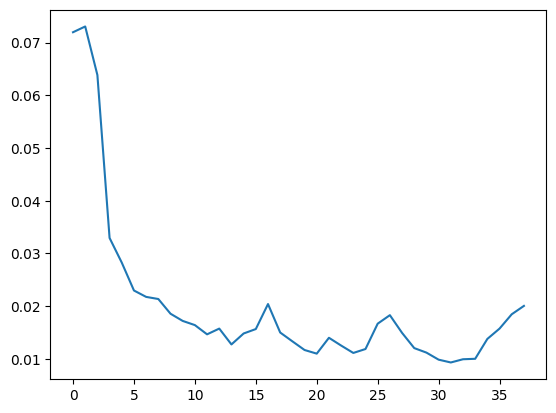

In [12]:
plt.plot(losses)
plt.show()

In [13]:
if False:
    torch.save(net.to("cpu").state_dict(), f"./model_{img_size}x{img_size}_b{default_bond_dims}.pt")

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
! ls -1

drive
model_28x28_b10.pt
sample_data


In [16]:
! cp model_28x28_b10.pt "/content/drive/MyDrive/Colab Notebooks/TN"